# Imaging Lab 3: Multipixel Scanning

## EECS 16A: Designing Information Devices and Systems I, Fall 2017

<!-- Any problems with lab deployment? Send an e-mail to Angie: angie.wang@eecs.berkeley.edu -->

**Name 1**:

**Login**: ee16a-

**Name 2**:

**Login**: ee16a-


## Table of Contents

#### [Generating Multipixel Scanning Matrices](#matrixGenIntro)
* [Imaging Mask Matrix Practice](#simpleMatrixGen)
* [Generating a Random Binary Mask Matrix](#randomBinaryMatrixGen)
    
#### [Imaging Simulator](#simulatorIntro)
* [Constructing an Ideal Sensor Model](#idealSensor)
* [Image Reconstruction Using the Ideal Sensor Model + Matrix Inverse](#idealReconstruction)
* [Handling System Non-Idealities](#nonidealities)
    * [Noise *(Why So Grainy? ☹)*](#noiseSimulation)
    * [Eigenanalysis & the Robustness of Inverse-Based Reconstruction](#conditionNum)
    * [Offset *(Or When "Dark" Just Isn't Dark Enough)*](#offsetSimulation)
    * [Prepping for Real Imaging: Intro to Non-Linearity *(Why Everyone Wants to Own an HDR Camera)*](#nonlinearityIntro)

#### [Hardware Setup](#breadboardSetup)

#### [Real Multipixel Imaging](#realImaging)

#### [Taste for the Future *(Advanced Techniques)*](#omp)
<!-- * [Least Squares Reconstruction](#leastSquares) -->
* [Compressed Sensing Magic (Orthogonal Matching Pursuit)](#omp)

#### [[Delving Further Into Non-Idealities]](#nonlinearitySimulation)
* [Non-Linearity, Unabridged](#nonlinearitySimulation)

## Overview

This week, you will experiment with imaging methods that illuminate *multiple pixels* at a time. The multipixel illumination patterns displayed by the projector will come from a random binary matrix that you will generate. Before performing real imaging with the projector and light sensor (phototransistor) circuit, you will first step through a simulation procedure that helps you understand how multipixel imaging works (with an encryption-y spin). You will get a little taste of "practical engineering" (i.e. why translating theory into practice isn't as easy as it looks). You'll then apply these insights to real multipixel imaging, and then see a cool "trick of the trade" that allows you to more quickly image your drawing and get a robust result!

*Note: A lot of the code to complete this lab will be provided for you to run. However, looking over the code to try to understand what it does is **highly encouraged**. Additionally, we will be writing **functions**, to enable multiple parts of this lab to reuse the same code with minimal copy + pasting.*

**<span style = "color: red">Run the following code block to get access to several pre-written functions and helper libraries.</span>**

In [13]:
%run scripts/helpers.py
%matplotlib inline

## <a id = 'matrixGenIntro'><span style = "color: blue">Generating Multipixel Scanning Matrices</span></a>

**Note: In lecture, we have been using 1 indexing, but this lab will use 0 indexing, as it makes the most sense in Python.**

Recall that we can define our imaging system by the following mathematical model:

$$ H \vec{i} = \vec{s} $$ 

Where $H$ is the imaging mask matrix, $\vec{i}$ is our image in column vector form, and $\vec{s}$ is the sensor reading column vector. 

Last week, we explored scanning our image one pixel at a time, where each row of our imaging mask matrix, $H$, corresponded to one scan of our image. This meant that scanning an image with $n$ pixels would require an $H$ with $n$ rows, so that the image could then be scanned exactly $n$ times (once per pixel). As an example, for a 2x2 image, $H$ would need exactly 4 rows (one for each mask), and we would make 4 scans.

Our first goal this week is to reconstruct an $n$ pixel image by illuminating pixels more than once, while ideally scanning the image $n$ times, just like in single pixel scanning. But how can we illuminate various pixels in an example 2x2 image more than once while using only 4 scans and 4 corresponding imaging masks? The solution is to illuminate more than one pixel per mask, which motivates the question: how does one choose which pixels to illuminate with each mask?

Begin by assigning each gray-scale pixel value in the 2x2 image to a variable, $iv_{ij}$, where $i$ is the row and $j$ is the column associated with the pixel location. <br/><br/>

<center>
**2x2 Image**
<img src="images/img_4x4.png" align="center" style="height:100px" />
</center>

<!--
In matrix form, the 2x2 image will look like this:
$$\begin{bmatrix} iv_{00} & iv_{01} \\ iv_{10} & iv_{11} \end{bmatrix}$$
-->

In our mathematical model above, we represent the 2x2 image as the 1D column vector: 

$$\vec{i} = \begin{bmatrix} iv_{00} \\ iv_{01} \\ iv_{10} \\ iv_{11} \end{bmatrix}$$

Likewise, the sensor reading column vector is represented as:

$$\vec{s} = \begin{bmatrix} sr_0 \\ sr_1 \\ sr_2 \\ sr_3 \end{bmatrix}$$

Where the sensor reading from the $k$th mask is $sr_k$.



To illustrate the relationship between the mask matrix $H$ (with per-row imaging masks $H_k$), the image vector $\vec{i}$, and the sensor reading vector $\vec{s}$, we provide you with this **Example System of Linear Equations:**

\begin{equation} 
iv_{00} = sr_0 \\
iv_{00} + iv_{01} = sr_1 \\
iv_{00} + iv_{10} = sr_2 \\
iv_{01} + iv_{10} + iv_{11} = sr_3
\end{equation}

**<span style = "color: red">*IMPORTANT*: The `Lab 3 System of Equations` and the `Example System of Linear Equations` are not at all related. Use the Lab 3 System of Equations for all parts of the lab that require it. The Example System of Linear Equations should only be used as a reference.</span>**

How would you represent these equations in terms of a matrix multiplication? Remember, the image vector $\vec{i}$ and sensor reading vector $\vec{s}$ are both 1D column vectors, but the imaging masks should be in matrix form ($H$), as illustrated below. <br/><br/>

<center>
**Imaging Mask Matrix $H$ for the Example System of Linear Equations**
<img src="images/mask_sample_4x4.png" align="center" style="height:200px" />
</center>

Each matrix element $H_{kl}$, where $k$ is its row and $l$ is its column, takes on one of two possible values: **white = 1** and **black = 0**.  

Recall that we *reshape* the $n$-element rows $H_k$ of the mask matrix into the masks (Mask $k$) themselves. To make sense of the $H$ matrix, it is helpful to look at each mask individually. As illustrated below, the 0th row of the example mask matrix will be reshaped into Mask 0 (see below) displayed by the projector. <br/><br/>

<center>
**Individual Masks for the Example System of Linear Equations**
<img src="images/H_4x4_split.png" align="center" style="height:200px" />
</center>

Now we can see that 

$$H_k \vec{i} = sr_k$$ 

represents a single equation in the system of equations. For example, the only term on the left hand side of the top equation is $iv_{00}$, which corresponds to the upper left pixel of the 2x2 image. This results from the fact that the upper left pixel of Mask 0 ($H_{00}$) is turned "on", while all other pixels of Mask 0 are "off", i.e.:

$$\begin{bmatrix} 1 & 0 & 0 & 0 \end{bmatrix} \begin{bmatrix} iv_{00} \\ iv_{01} \\ iv_{10} \\ iv_{11} \end{bmatrix} = sr_0$$

### <a id = 'simpleMatrixGen'><span style = "color: blue">Imaging Mask Matrix Practice</span></a>

Now that we have an understanding of how to approach multipixel scanning, let's test our approach on a new system of equations:

<center>
**Lab 3 System of Equations**

$$iv_{00} + iv_{01} + iv_{10} = sr_0$$
$$iv_{00} + iv_{11} = sr_1$$
$$iv_{01} + iv_{11} = sr_2$$
$$iv_{10} + iv_{11} = sr_3$$

**<span style="color: red">For a 2x2 image represented by $\vec{i}$, create the matrix `H` such that $ H \vec{i} = \vec{s} $ represents the `Lab 3 System of Equations` above.</span>**

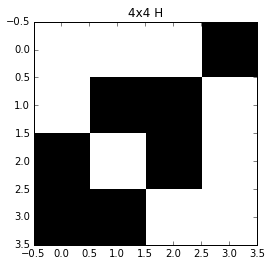

In [14]:
import numpy as np

# TODO: Create H (4x4) for the Lab 3 System of Equations --------------------
H = np.matrix([[1, 1, 1, 0], [1, 0, 0, 1], [0, 1, 0, 1], [0,0,1,1]])

# Show H
plt.imshow(H, cmap = 'gray', interpolation = 'nearest')
plt.title('4x4 H')

As stated above, we will *reshape* rows $H_k$ of the mask matrix, $H$, into the individual masks themselves. 

**<span style="color: red">You will help to write a function `showMasks` that enables you to iterate through the 4 individual masks and display them as 2x2 images (1 TODO). Double check that the generated masks make sense visually and have the expected number of illuminated pixels. The `showMasks` function will be reused later.</span>**

*Hint: Reference your code from last week where you checked to make sure that the scanning matrix was producing the correct pattern by displaying each of the individual masks. Check out the command `np.reshape`.* 

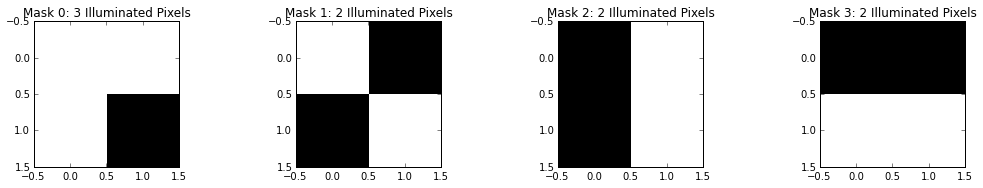

In [15]:
# Inputs
#  `H`: Mask matrix
#  `X`: Image width
#  `Y`: Image height
#  `numMasksShown`: Number of individual masks to display (starting from `H` row 0)
def showMasks(H, X, Y, numMasksShown):
    plt.figure(figsize = (18, 12)) 
    # Use this for loop to iterate through the first `numMasksShown` rows of `H` 
    # you want to display.
    for k in range(numMasksShown):
        plt.subplot(numMasksShown, numMasksShown, k + 1)
    
        # TODO: Reshape the `k`th row of `H` to be shown in 2D --------------------
        # Hint: `X` is the width of the image you want to observe; `Y` is its height
        mask = H[k]
        mask = np.reshape(mask, (X,Y))
  
        plt.imshow(mask, cmap = 'gray', interpolation = 'nearest')
        # Title also prints number of illuminated (white) pixels per mask
        plt.title('Mask ' + str(k) + ': ' + str(np.sum(H[k])) + ' Illuminated Pixels')
    plt.show()

# Show individual masks    
showMasks(H = H, X = 2, Y = 2, numMasksShown = 4)

### <a id = 'randomBinaryMatrixGen'><span style = "color: blue">Generating a Random Binary Mask Matrix</span></a>

A 2x2 image is not very interesting to scan, so we will instead try to scan a 32x32 region. Note that this image has different dimensions compared to last week's image!

**<span style="color: red">To scan a 32x32 image, what dimensions must our scanning matrix $H$ have? What does the number of rows of $H$ correspond to? What does the number of columns correspond to? What do the elements in each column of $H$ represent?</span>**

Scanning Matrix H: 1024x1024;
Number of rows = number of masks;
number of columns = number of pixesls per image;
whether that pixel in that mask is illuminated

Since we'd like to use a sufficiently interesting set of masks and you *really* don't want to be constructing such a large matrix by hand, we will provide you with a function that generates a random binary mask matrix $H$ for you, given dimensions `(X, Y)` corresponding to your image's width/height, and, as we'll go into later, a parameter for the average number of illuminated pixels per scan. The resulting matrix $H$ will consist entirely of 0's and 1's, where 1's are randomly interspersed among 0's, and each row will contain approximately **`avg1sPerRow`** (see function arguments) # of 1's. Not all rows will contain the same number of 1's!

**<span style="color: red">Run the `generateRandomBinaryMask` function and visually inspect that the generated `H` (with approximately 300 pixels illuminated per scan) has the right dimensions & visually looks random. `Going forward, any time a coding part of this lab references H, we're referring to this generated H.` Don't worry too much about how this function is actually implemented, but you can check out the code in `scripts/helpers.py`.</span>** 

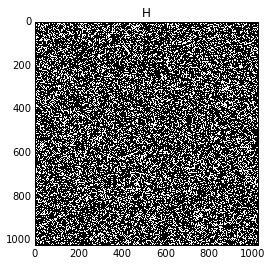

In [16]:
# Generate the H mask
H = generateRandomBinaryMask(avg1sPerRow = 300)

**<span style="color: red">Use the `showMasks` function created earlier to show the first 4 individual masks (rows 0 to 3 of `H`) as 32x32 images.</span>**

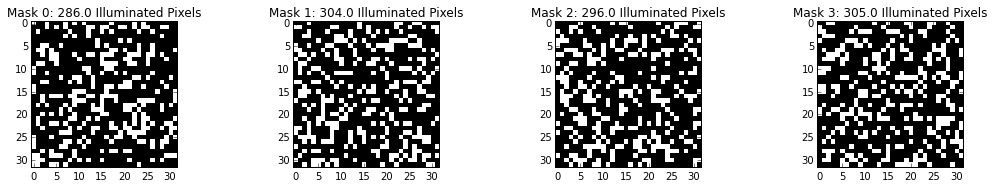

In [17]:
# TODO: Reuse the `showMasks` function from earlier to display the first 4 masks of H. -------
showMasks(H, 32, 32, 4)

Think back to the representation of the imaging system as taking a matrix-vector product. Recall that in last week's imaging lab, you reconstructed the image column vector $\vec{i}$ from the sensor reading vector $\vec{s}$ by applying the equation:

$$\vec{i} = H^{-1} \vec{s}$$

You used the **identity** matrix for $H$, for which the inverse $H^{-1}$ exists. In order to apply the same reconstruction method assuming a randomly generated binary $H$, you first need to make sure that your $H$ is actually invertible. 

**<span style="color: red">How can you use Gaussian elimination to check that the square matrix $H$ is invertible? What must be true about the rows of $H$ for it to be invertible?</span>**

For it to be invertible, the rows must be linearly independent, and gaussian elimination will result in the identity matrix.

**Note on invertibility**

Luckily, randomly generated binary matrices are *usually* invertible. However, the function we provided still double checks that the generated $H$ is indeed invertible (using an alternative method to Guassian elimination), and re-generates the matrix if it's not.

## <a id = 'simulatorIntro'><span style = "color: blue">Imaging Simulator</span></a>

Let's take a detour before we start capturing real images with the projector. Many of you noticed during Imaging Lab 2 that when the projector is displaying a black screen, there is still a lot of light inside the box. This is a limitation of the projector that, along with many other real system non-idealities, greatly affects our ability to reconstruct the image using the light sensor data. To understand how our imaging system operates, it's thus important to build a simulator that **accurately models** what happens when we try to capture an image, including non-idealities that we can potentially compensate for. 

### <a id = 'idealSensor'><span style = "color: blue">Constructing an Ideal Sensor Model</span></a>

Let's first construct a function that emulates what we would *hope* occurs in the box. An image (represented as the column vector $\vec{i}$) is placed in a region that can be illuminated by the projector. The projector projects a sequence of masks $H_k$ onto the image (illuminating certain pixels at a time), and the digitized light sensor output ($sr_k$, an entry of the column vector $\vec{s}$) is read for each scan $k$.

Recall that these operations can be represented by the previously defined mathematical model:

$$\vec{s} = H \vec{i}$$ 

**<span style="color:red"> Your first goal is to translate this ideal model into a `simulateIdealCapture` function (Fill in the 2 TODOs). Apply the function using the supplied 32x32 image of a playing card and your generated random binary matrix `H`. Display the simulated sensor readout as a 32x32 image.</span>**

*Hint: Remember to use `np.dot` to do matrix multiplication.*

The card you're trying to image should look like: <br/><br/>

<center>
<img src="images/raw_card.png" align="center" style="height:200px" />
</center>

Think about what the output sensor readings will look like. Given randomly generated masks, would you expect the output sensor readings to be remotely recognizable?

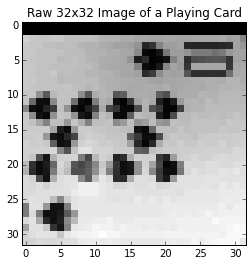

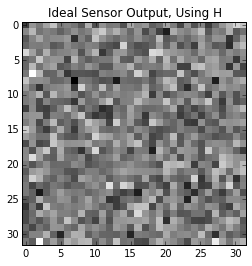

In [18]:
# Inputs: 
#  `i2D`: 2D image you're trying to capture
#  `H`: Mask matrix
#  `matrixName`: Name of mask matrix (for image title)
#  `display`: Whether to display the sensor output as a 2D image
# Outputs:
#  `s`: Sensor reading column vector
def simulateIdealCapture(i2D, H, matrixName, display = True):
    # Number of pixels in your image = `iHeight` * `iWidth`
    iHeight = i2D.shape[0]
    iWidth = i2D.shape[1]
    iSize = iHeight * iWidth
    
    # Convert the 2D image `i2D` into a 1D column vector `i` 
    i = np.reshape(i2D, (iSize, 1))
    
    # TODO: Perform the matrix operation to emulate the ideal imaging system  --------------
    s = np.dot(H, i)
    
    if (display):
        
        # Reshape the simulated sensor output `s` into an appropriately 
        # sized 2D matrix `s2D` and plots it
        s2D = np.reshape(s, (iHeight, iWidth))
        plt.imshow(s2D, cmap = 'gray', interpolation = 'nearest')
        plt.title('Ideal Sensor Output, Using %s' % matrixName)
        plt.show()
    return s;

# Load card image + display it
i2D = np.load('scripts/raw_card.npy')
plt.imshow(i2D, cmap = 'gray', interpolation = 'nearest')
plt.title('Raw 32x32 Image of a Playing Card')
plt.show()

# Simulate the image capture step (ideal)
s = simulateIdealCapture(i2D = i2D, H = H, matrixName = 'H');

### <a id = 'idealReconstruction'><span style = "color: blue">Image Reconstruction Using the Ideal Sensor Model + Matrix Inverse</span></a>

As you can see, for *multipixel imaging*, the sensor output does not resemble the original image in any way. By applying the randomly generated mask matrix $H$, you've essentially encrypted the image data and made it unrecognizable to anyone who doesn't know the exact mask matrix $H$ you used (otherwise known as the encryption key).

If you know the key $H$, as stated before, you can reconstruct/decrypt the desired image column vector $\vec{i}$ from the sensor reading vector $\vec{s}$ by essentially *undoing* what the imaging system did to the image and applying the equation:

$$\vec{i} = H^{-1} \vec{s}$$

Again, it's important that we've selected an invertible $H$. 

**<span style="color:red">Now your job is to help write a function `idealReconstruction` (Fill in the TODO) that accepts the column vector $\vec{s}$ and mask matrix $H$ and displays the reconstructed estimate of $\vec{i}$ as a 2D image. Run the reconstruction function using the previously computed `s` and mask matrix `H` and verify that it worked as you expected.</span>**

*Hint: Use `np.linalg.inv` to invert a matrix.*

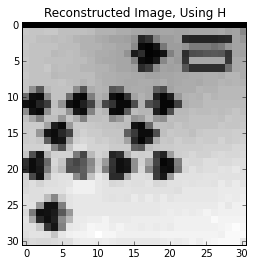

In [19]:
# Inputs
#  `H`: Mask matrix
#  `matrixName`: Name of mask matrix (for image title)
#  `s`: Sensor reading column vector
#  `X`: Image width
#  `Y`: Image height
def idealReconstruction(H, matrixName, s, X = 32, Y = 32, realImaging = False):
    
    # TODO: Perform the matrix operations required for reconstruction --------------------
    i = np.dot(np.linalg.inv(H), s)
    
    if realImaging:
        i = noiseMassage(i, H)
    
    # Reshape the column vector `i` to display it as a 2D image
    i2D = np.reshape(i, (Y, X))    
    # We're going to exclude the top row and left-most column from display
    plt.imshow(i2D[1:, 1:], cmap = 'gray', interpolation = 'nearest')
    plt.title('Reconstructed Image, Using %s' % matrixName)
    plt.show()


# Run ideal reconstruction    
idealReconstruction(H = H, matrixName = 'H', s = s)

### <a id = 'nonidealities'><span style = "color: blue">Handling System Non-Idealities</span></a>

The ideal reconstruction demonstrated above works great, right? Unfortunately, due to real-world non-idealities alluded to earlier, if you directly tried to image a drawing with the multipixel masks in $H$, the reconstruction would probably look terrible. A significant amount of engineering effort is focused on how to best translate theory into practice by attempting to compensate for or remove non-idealities. In the following sections, we'll look at some of the worst offenders and what we can do to improve reconstruction quality.

#### <a id = 'noiseSimulation'><span style = "color: blue">Noise *(Why So Grainy? ☹)*</span></a>

Although we won't be talking about noise in any real detail (that's something covered in more advanced classes), it's important to realize that both the light sensor circuit and the projector add noise that shows up in the digitized sensor output. Noise is what causes photos to look grainy or fuzzy. As an example, if your single pixel imaging system from last week happened to be very noisy (and usually, the cheaper $ the system, the noisier it is...), imaging the card from before might've produced something like: <br/><br/>

<center>
<img src="images/noisy_card.png" align="center" style="height:200px" />
</center>

The noisier your system, the less the resultant image will look like what you expected ☹.

One way to make noise less "relevant" is to increase the number of pixels illuminated per scan. This increases the "signal level" (i.e. contributions from things we actually care about). At the same time, the amount of noise coming from the light sensor circuit and projector should stay mostly constant, thus improving the so-called *signal-to-noise ratio* (SNR) of our system. This is important to know when choosing `avg1sPerRow` for our random binary mask.

Another way to make noise less "relevant" is to repeat each scan $k$ (with the same illumination pattern) many times and *average* the sensor outputs. The desired signal is always present, but the *random* error (noise) changes on each repeat scan. Thus, you can "average out the noise" at the expense of spending more time acquiring the image. This is actually what the Launchpad code you will use does under the hood.

Generally speaking, we would like to build a sensing system that is as robust to noise as possible, but what does that entail?

#### <a id = 'conditionNum'><span style = "color: blue">Eigenanalysis & the Robustness of Inverse-Based Reconstruction</span></a>

When noise is included, the mathematical model of our imaging system would look like:

$$ \vec{s} = H \vec{i} + \vec{w} $$

Where the elements ($w_k$) of the column vector $\vec{w}$ correspond to the random amounts of noise added at each measurement $sr_k$. If we attempt to get an estimate of the image $\vec{i_{est}}$ with matrix inversion ($H^{-1}$), we'd expect:

$$ \vec{i_{est}} = H^{-1} \vec{s} = \vec{i} + H^{-1} \vec{w} $$

Remember that we were hoping to solve for just $\vec{i}$! The additional undesired term $H^{-1} \vec{w}$ is what we call our reconstruction *error*, which results from linearly transforming the original noise vector $\vec{w}$ by $H^{-1}$. This implies that our choice of $H$ (and therefore $H^{-1}$) strongly influences how robust our overall imaging system is. 

To build some intuition on why this is the case, recall that matrix-vector multiplication $A \vec{x} = \vec{b}$ linearly transforms $\vec{x}$ into $\vec{b}$ via scaling and rotation, as designated by $A$. Additionally, recall that the eigenvalues $\lambda_i$ and $n$ length eigenvectors $\vec{v_{\lambda_i}}$ of an $n \times n$ matrix $A$ can be found by solving for:

$$A \vec{v_{\lambda_i}} = \lambda_i \vec{v_{\lambda_i}}$$

This equation says that applying $A$ to an eigenvector $\vec{v_{\lambda_i}}$ simply scales it by the corresponding eigenvalue $\lambda_i$ without changing its direction. It also implies that the result of multiplying any vector by $A$ is determined by $A$'s eigenvalues and corresponding eigenvectors.

A good illustration of this is repeated below (from [Wikipedia](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors#Two-dimensional_matrix_example)):

The transformation matrix

$$ A = \begin{bmatrix} 2 & 1 \\ 1 & 2 \end{bmatrix} $$

has the following eigenvalues and eigenvectors:

$$ \lambda_1 = 1: \vec{v_{\lambda_1 = 1}} = \alpha \begin{bmatrix} 1 \\ -1 \end{bmatrix}, \alpha \in \mathbb{R}, \alpha \neq 0 $$

$$ \lambda_2 = 3: \vec{v_{\lambda_2 = 3}} = \beta \begin{bmatrix} 1 \\ 1 \end{bmatrix}, \beta \in \mathbb{R}, \beta \neq 0 $$

<center>
<img src="images/Eigenvectors-extended.gif" align="center" style="height:300px" />
<figcaption>[Wikipedia](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors#Two-dimensional_matrix_example)</figcaption>
</center>

The eigenspace of $\lambda_i$ is defined as the union of the zero vector and the set of all eigenvectors corresponding to $\lambda_i$. In the previous figure, the eigenspace of $\lambda_1$ is represented by the thin pink line. The eigenspace of $\lambda_2$ is represented by the thin blue line. 

Notice that a transformation by $A$ preserves the directions of *all vectors* in parallel with either eigenspace (i.e. the thick blue/pink vectors). The blue/pink vector lengths are scaled by corresponding eigenvalues (3x for the blue vectors, 1x for the pink vectors). On the other hand, the vectors in red (not parallel to either of the eigenspaces) are rotated some amount by $A$. 

It's important to observe that any arbitrary vector close in direction (=parallel or almost parallel) to a $\vec{v_{\lambda_i}}$ of $A$ will have its length be strongly affected by the corresponding eigenvalue $\lambda_i$. An $\vec{x}$ that's parallel or nearly parallel to a $\vec{v_{\lambda_i}}$ associated with a very large absolute $\lambda_i$ will be stretched significantly more than an $\vec{x}$ parallel to a $\vec{v_{\lambda_i}}$ associated with a very small absolute $\lambda_i$; actually $\vec{x}$ would be shrunk in the latter case if $|\lambda_i| < 1$.

**<span style=\"color:red\">To better understand the intuition behind eigenvalues and eigenvectors, it's always instructive to construct and visualize a simple 2D example. We'll be using `plotVec2D` to help us visualize how eigenvalues affect some vectors</span>**

**<span style="color:red">Your goal now is to write code to:</span>**

1. Create the transformation matrix:
$$ A = \begin{bmatrix} 3 & 2 \\ 4 & 5 \end{bmatrix} $$
<br>

2. Find the eigenvalues and associated eigenvectors of $A$. *Hint: check out the function [np.linalg.eig](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.eig.html), which returns a tuple consisting of the eigenvalues of $A$ and corresponding eigenvectors. Be especially careful about how the eigenvectors are returned! Note that you can access the $c$th column of a matrix $M$ via `M[:, c]`.*
<br><br>

3. Use `plotEigenVec2D` to plot (on the same figure) *each* of the eigenvectors and label them with their corresponding eigenvalue.
<br><br>

4. Generate the 2 column vectors that we want to transform with $A$:
$$\vec{x_1} = \begin{bmatrix} -0.2 \\ 0.25 \end{bmatrix}$$
<br>
$$\vec{x_2} = \begin{bmatrix} -0.2 \\ -0.5 \end{bmatrix}$$
<br>

5. Again on the same figure, plot (and label) $\vec{x_1}$ and $\vec{x_2}$ using `plotVec2D`.
<br>

**In the code block below, implement steps 1. and 2.**

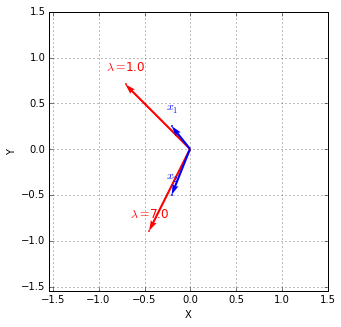

In [20]:
plt.figure(figsize = (5, 5))
plt.grid()

# TODO: 1. Create the transformation matrix A described above
# NOTE: Do NOT make a numpy array, make a 2D list
A =[[3,2], [4,5]]

# TODO: 2. Find the eigenvalues and associated eigenvectors of A
eigVals, eigVecs =np.linalg.eig(A)

for i in range(len(eigVals)): # 3. Plot the eigen vectors
    plotEigenVec2D(eigVecs[:, i], eigVals[i])
    
x1 = np.transpose([-0.2, 0.25])
x2 = np.transpose([-0.2, -0.5]) 

# 4. Label the vectors
plotVec2D(x1, r'$x_1$')
plotVec2D(x2, r'$x_2$')

**<span style="color:red">From observing the plot, do you expect $A$ to stretch (a.k.a. amplify the magnitude of) $x_1$ or $x_2$ more? Why (in terms of eigenvalues + eigenvectors)?</span>**

You would expect A to stretch x2 more, because the eigenvalue in that direction is 7x larger.

**<span style = "color: red">Run the code block below to plot and labe) $\vec{x_1}$ and $\vec{x_2}$. Then we will compute, plot, and label $A \vec{x_1}$ and $A \vec{x_2}$ to see that your statement above is true. **

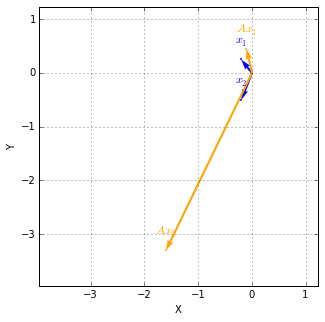

In [21]:
plt.figure(figsize = (5, 5))
plt.grid()

plotVec2D(x1, r'$x_1$')
plotVec2D(x2, r'$x_2$')

Ax1 = np.dot(A, x1)
Ax2 = np.dot(A, x2)

plotVec2D(Ax1, r'$A x_1$', color = "orange")
plotVec2D(Ax2, r'$A x_2$', color = "orange")

Recalling that our reconstruction error is given by $H^{-1} \vec{w}$, this means that the noise vector $\vec{w}$ can be disastrously amplified in the directions associated with very large eigenvalues of $H^{-1}$, resulting in unintelligible reconstruction.

Going backwards, if $H^{-1}$ has very large eigenvalues, $H$ will have very small (i.e. close to zero) eigenvalues and be "ill-conditioned." One can prove that, for an invertible matrix $A$, if $\lambda_i$ is an eigenvalue of $A$, then $\frac{1}{\lambda_i}$ is an eigenvalue of $A^{-1}$ i.e.:

$$A^{-1} \vec{v_{\lambda_i}} = \frac{1}{\lambda_i} \vec{v_{\lambda_i}} $$

Intuitively, when small eigenvalues of $H$ exist, corresponding eigenvalues of $H^{-1}$ blow up (think about what happens when you divide by numbers really close to zero), and noise is greatly amplified. 

For this next section, we will use the function `createMysteryMatrix` to generate a pseudo-random (i.e. looks pretty random, but is generated in a formulaic way) called the "mystery matrix" that has interesting properties useful in many applications. We will also use the function `eigenanalysis` that plots a histogram of the magnitudes of the eigenvalues of your $H$'s and their respective inverses (x axis = magnitude bins, y axis = number of eigenvalues within the bin's magnitude range). 

<!---
**<span style="color:red">Your goal is to write code to:</span>**

1. Create the matrix `mysteryH` (*use this name!*) using the function `createMysteryMatrix`. *Note that the shape of `mysteryH` should be the same as that of the random binary `H`.* 
<br><br>

2. Study the eigenvalues of `H` and `mysteryH` using the function `eigenanalysis`. Be sure to label your plots (see the function argument `matrixName`)!
<br><br>

3. Generate the inverses: `H`$^{-1}$ and `mysteryH`$^{-1}$.
<br><br>

2. Study the eigenvalues of `H`$^{-1}$ and `mysteryH`$^{-1}$ using the function `eigenanalysis`. Be sure to label your plots!
--->

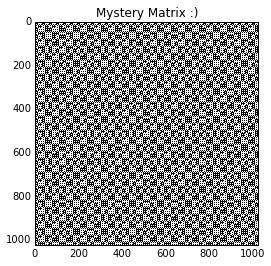

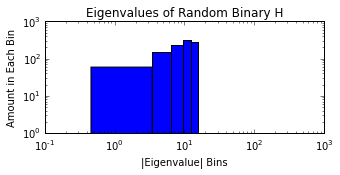

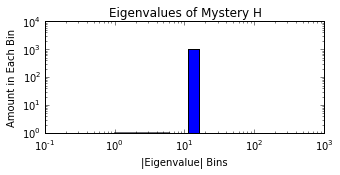

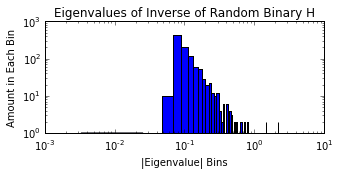

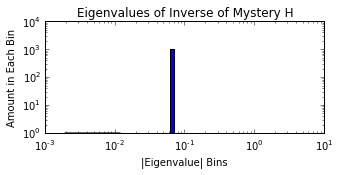

In [22]:
# Creates the mysteryH mystery matrix with interesting, useful properties
mysteryH = createMysteryMatrix(shape = H.shape)

# Plot the eigenvalues of both H and mysteryH
eigenanalysis(H = H, matrixName = 'Random Binary H')
eigenanalysis(H = mysteryH, matrixName = 'Mystery H')

HInv = np.linalg.inv(H)
mysteryHInv = np.linalg.inv(mysteryH)

# Plot the eigenvalues of both the inverse of H and the inverse of mysteryH
eigenanalysis(H = HInv, matrixName = 'Inverse of Random Binary H')
eigenanalysis(H = mysteryHInv, matrixName = 'Inverse of Mystery H')

**<span style="color:red">Which of the two matrices `H` and `mysteryH` do you think is more noise robust and would result in a better reconstruction? Justify your answer using the eigenvalue histograms above.</span>**

The mystery is better noise conditioned, because it's eigenvalues are larger.

We'll provide you with a function `simulateCaptureWithNoise` that models noise added to the sensor output, so that you can see for yourself how noise robust these matrices are. The function adds noise to the output of `simulateIdealCapture`, which you helped to write earlier. Don't worry too much about exactly how the noise is added. We provide you with a mechanism (**sigma**, corresponding to noise *standard deviation*--the larger the $\sigma$, the more noisy the image will look) to add different amounts of noise. 

**<span style="color:red">First, just run the next code block so that you'll have access to `simulateCaptureWithNoise` below.</span>**

In [23]:
# Inputs: 
#  `i2D`: 2D image you're trying to capture
#  `H`: Mask matrix
#  `matrixName`: Name of mask matrix (for image title)
#  `sigma`: Amount of noise to add (noise standard deviation)
# Outputs:
#  `s`: Sensor reading column vector with noise added
def simulateCaptureWithNoise(i2D, H, matrixName, sigma):
    # Get ideal image capture (without noise)
    idealS = simulateIdealCapture(i2D = i2D, H = H, matrixName = matrixName, display = False)
    # Noise of mean 0, with standard deviation `sigma` is added to each element of the
    # original column vector s
    noise = np.random.normal(0, sigma, H.shape[0])
    noise = np.reshape(noise, (H.shape[0], 1))
    s = idealS + noise
    return s;

**<span style="color:red">You will simulate the imaging system with different amounts of noise added. Run the code block below to iterate through `sigmas = [1, 10, 100]`.</span>**

<!---
1. Print the current sigma as `Sigma: #`. (It's always important to label your results!)
<br><br>

2. Use `simulateCaptureWithNoise` to simulate capturing the 2D image `i2D` with the mask matrix `H` and the current noise `sigma`. Don't forget to provide the matrix name `H` for labelling purposes!
<br><br>

3. Use `idealReconstruction` to reconstruct the original image from the captured data. Again, don't forget to provide the matrix name!
<br><br>

4. Repeat steps 2 and 3, replacing `H` with `mysteryH`!

*You should have generated 6 images total. Check to see that the results agree with your statements earlier.*
--->

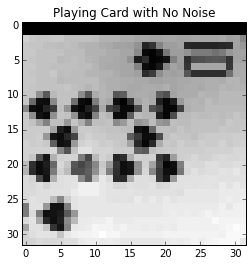

Sigma: 1


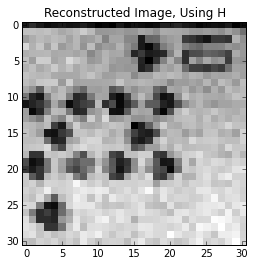

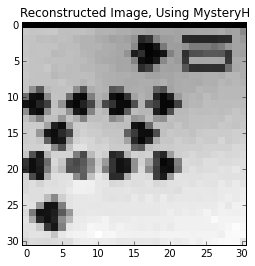

Sigma: 10


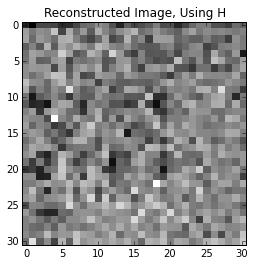

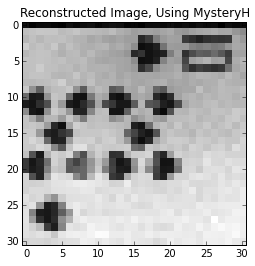

Sigma: 100


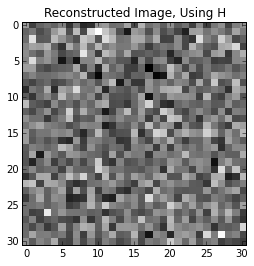

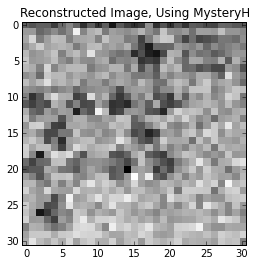

In [24]:
sigmas = [1, 10, 100]

# Load card image + display it
i2D = np.load('scripts/raw_card.npy')
plt.imshow(i2D, cmap = 'gray', interpolation = 'nearest')
plt.title('Playing Card with No Noise')
plt.show()

for sigma in sigmas:
    
    print("Sigma: " + str(sigma))
    
    sWithH = simulateCaptureWithNoise(
        i2D = i2D, 
        H = H, 
        matrixName = 'H', 
        sigma = sigma
    )   
    
    idealReconstruction(H = H, matrixName = 'H', s = sWithH)
        
    sWithMysteryH = simulateCaptureWithNoise(
        i2D = i2D, 
        H = mysteryH, 
        matrixName = 'MysteryH', 
        sigma = sigma
    )
    
    idealReconstruction(H = mysteryH, matrixName = 'MysteryH', s = sWithMysteryH)

#### <a id = 'offsetSimulation'><span style = "color: blue">Offset *(Or When "Dark" Just Isn't Dark Enough)*</span></a>

Have you ever noticed that you still see some light coming from a monitor displaying a black screen in a completely dark room? In the case of LCD monitors, this is due to a phenomenon called backlight bleeding, as shown below.<br/><br/>

<center>
<img src="images/dark-screen.png" align="center" style="height:200px" />
[[Source]](http://www.overclock.net/t/1554978/lightbox/post/23893758/id/2450326)
</center>

You'll notice that a similar thing happens with our imaging setup: there is still some amount of unwanted light visible in the box, even when the projector is displaying a completely black image. Bad things happen because our light sensor picks up this undesired "signal". If the model of our ideal (noiseless) imaging system is: 

$$ \vec{s} = H \vec{i} $$

The undesired light can be modeled as a constant "offset" $o$ affecting the sensor reading as follows:

$$ \vec{s} = H \vec{i} + o $$

Without this offset, we expect a "0" sensor reading associated with a mask consisting entirely of 0's. However, because of this offset, the sensor reading associated with a black mask will instead be $o$. Likewise, a sensor reading $sr_k = 200$ for an ideal imaging system would instead be $sr_k = 200 + o$ when this offset is present.

**<span style="color:red">You will help to write a function `simulateCaptureWithNoiseAndOffset` that models both noise added to the sensor output *and* the undesired offset previously mentioned. This function should add an offset `o` to the output of `simulateCaptureWithNoise`, which already includes the noise (1 TODO).</span>**

In [25]:
# Inputs: 
#  `i2D`: 2D image you're trying to capture
#  `H`: Mask matrix
#  `matrixName`: Name of mask matrix (for image title)
#  `o`: Offset (i.e. for a projected dark image)
#  `sigma`: Amount of noise to add (noise standard deviation)
# Outputs:
#  `s`: Sensor reading column vector with noise + offset added
def simulateCaptureWithNoiseAndOffset(i2D, H, matrixName, o, sigma):
    
    s = simulateCaptureWithNoise(i2D = i2D, H = H, matrixName = matrixName, sigma = sigma)
    # TODO: Add offset (o) to your imaging model --------------------
    s_withOffset = s + o
    
    return s_withOffset;

**<span style="color:red">Next, you will simulate the imaging system with different amounts of offset. `offsets = [1, 10, 100]`</span>**

<!---
1. Print the current `o` as `Ambient Offset: #`.
<br><br>

2. Use `simulateCaptureWithNoiseAndOffset` to simulate capturing the 2D image `i2D` with the mask matrix `H` (not mysteryH), a noise `sigma = 0` (ignoring noise for now), and the current ambient offset `o`. Don't forget to provide the matrix name `H` for labelling purposes!
<br><br>

3. Use `idealReconstruction` to reconstruct the original image from the captured data. Again, don't forget to provide the matrix name!

*You will see how the amount of offset affects ideal reconstruction (total of 3 reconstructed images).*
--->

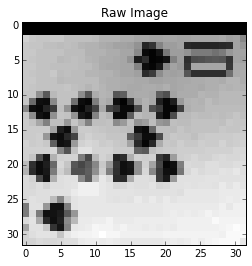

Offset: 1


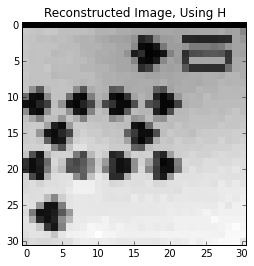

Offset: 10


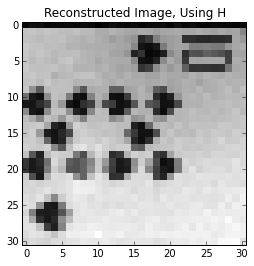

Offset: 100


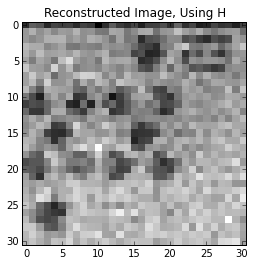

In [26]:
offsets = [1, 10, 100]

# Load card image + display it
i2D = np.load('scripts/raw_card.npy')
plt.imshow(i2D, cmap = 'gray', interpolation = 'nearest')
plt.title('Raw Image')
plt.show()

for o in offsets:
    print("Offset: " + str(o))
    s = simulateCaptureWithNoiseAndOffset(i2D = i2D, H = H, matrixName = 'H', o = o, sigma = 0.001)
    idealReconstruction(H = H, matrixName = 'H', s = s)

As you can see, when `H` is used, the more undesired light there is, the worse the reconstruction gets :(.

The exact amount of offset $o$ varies depending on the particular projector setup you use (the more expensive the projector, the less it probably is) and your chosen brightness settings. 

Luckily, the offset is a value that we can figure out, simply by projecting a black image and getting the sensor reading! To get a more accurate sense of this offset (when noise is present), we'll get a couple of sensor readings with this black image and take an average. 

We have to take several steps to measure "black" (with the unwanted light), but you're not required to understand what they do. If you want to learn more, refer to [details](#offset) at the end of the notebook.

We will provide a function `addOffsetCalibrationToH` that adds in 32 black characterization rows to $H$. We will also provide a function `getOffsetEstimateAndS` that separates out the offset estimation from the original sensor reading vector (as a tuple). Note that when offset calibration is performed, the original sensor reading vector will be 32 rows longer.

**<span style="color:red">You will help to write a function `reconstructionWithOffsetRemoval` (1 TODO) that uses this offset estimate `oest` to "remove" the offset from measurements in `s` before applying `idealReconstruction`.</span>**

*Hint: Think about the way we modeled the undesired light and try subtracting the estimated offset from each $sr_k$.*

We will then use our functions to simulate the sequence of tasks needed to capture an image using the random binary mask matrix `H`, remove the offset (a large offset `o = 100` is used), and reconstruct the image. Noise isn't considered (`sigma = 0.001`) for now. If your calibration worked, you should see that the card image was properly reconstructed, even with a large undesired offset.

*Pay attention to this task sequence (and especially which matrices are used where), as a similar one will be used later for real imaging!*

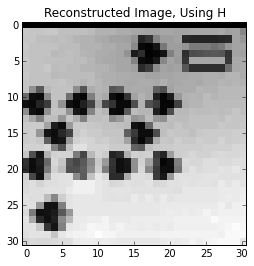

In [27]:
# Inputs
#  `H`: Mask matrix (without extra rows)
#  `matrixName`: Name of mask matrix (for image title)
#  `s`: Original sensor reading vector (without extra rows)
#  `oest`: Estimate of undesired offset
def reconstructionWithOffsetRemoval(H, matrixName, s, oest, realImaging = False):
    
    # TODO: Remove the estimated offset from measurements --------------------
    sWithoutOffset = s - oest
    
    idealReconstruction(H = H, matrixName = matrixName, s = sWithoutOffset, realImaging = realImaging)

# Step 1: Add offset calibration rows to H
HWithOffsetCalibration = addOffsetCalibrationToH(H = H)
# Step 2: Perform imaging
sWithOffsetCalibration = simulateCaptureWithNoiseAndOffset(
    i2D = i2D, 
    H = HWithOffsetCalibration, 
    matrixName = 'H', 
    o = 100, 
    sigma = 0.001
)
# Step 3: Estimate the offset
oest, s = getOffsetEstimateAndS(sWithOffsetCalibration = sWithOffsetCalibration)
# Step 4: Use ideal reconstruction after removing the offset (note that H is used here)
reconstructionWithOffsetRemoval(H = H, matrixName = 'H', s = s, oest = oest)

**THIS SHORT BLURB IS OPTIONAL BUT IT'S GOOD BACKGROUND INFO!**

#### <a id = 'nonlinearityIntro'><span style = "color: blue">Prepping for Real Imaging: Non-Linearity *(Why Everyone Wants to Own an HDR Camera)*</span></a>

Have you ever tried to record a really loud concert with your phone only to play back the sound and have it sound extremely distorted and uncomfortable to listen to? This "audio clipping" is the result of a phenomenon called non-linear distortion that affects all sensing systems. You will learn more about nonlinear distortion in advanced circuits classes, but we'll give you a little introduction here.

Although "audio clipping" is probably one of the more intuitive examples of nonlinear distortion, this phenomenon also affects imaging systems. If you have recently been in the market for a smart phone with a good camera, you probably will have heard of companies marketing a feature called HDR, or high dynamic range. Check out two photos, one taken with HDR and one with HDR turned off. <br/><br/>

<center><img src="images/hdr.png" align="center" style="height:150px;"/>
[[Source: Google Research]](https://research.googleblog.com/2014/10/hdr-low-light-and-high-dynamic-range.html)</center>

The photo taken with low dynamic range looks kind of washed out. That is, regions of the view above a certain brightness all start looking the same (i.e. mostly white), even though in reality, there is a lot more variation in those regions. When HDR is turned on, the details in those regions are maintained in the final photo. 

In this case, HDR is achieved in software, but in general, the "analog" imaging hardware itself has dynamic range limitations that would affect the photo in similar ways. Again, the more $$$ you pay, the better the dynamic range that the sensor will have. 

*Note: We mention non-linearity here, because we need to compensate for it during real imaging. Non-linearity is outside the scope of this class, but if you're interested in understanding it in more detail (pending time), feel free to read and work through the problems in the [supplement](#nonlinearitySimulation) at the end of this lab. This is completely OPTIONAL.*

We provide a function `packageMaskMatrix` that packages your mask `matrix` into a file that `capture_image.py` (the same `capture_image.py` used in Imaging 2) can read. The packaged matrix includes rows for *offset characterization* (as detailed in the previous section). When `mysteryH` is packaged, a mask consisting fully of 1's (too bright for our sensor!) is split into two separate masks to guard against the non-linearity of our ambient light sensor.  

**END OF OPTIONAL SECTION**

**<span style="color:red">Before moving onto real imaging, run the code block below to generate mask matrix files.</span>**

Check that `packageMaskMatrix` generated the following files in your lab directory:
* **H.npy** - Saved `H` for restoring in case you have to close out of your Jupyter notebook. 
* **H_packaged.npy** - Packaged `H` used by `capture_image.py` **(contains extra rows)**.
* **mysteryH.npy** - Saved `mysteryH` for restoring in case you have to close out of your Jupyter notebook.
* **mysteryH_packaged.npy** - Packaged `mysteryH` used by `capture_image.py` **(contains extra rows)**.

In [28]:
# Generate mask matrix files    
packageMaskMatrix(H, 'H')
packageMaskMatrix(mysteryH, 'mysteryH')
print("Done! :)")

Done! :)


##  <span style="color:red">**IMPORTANT**</span>: <a id ='breadboardSetup'><span style = "color: blue">Hardware Setup</span></a>

### Hardware setup instructions (replicated from Imaging 2) are linked [here](ee16a_imaging_setup.pdf) for your convenience. Please follow instructions verbatim to get consistent results. 

<a id='singlePixel'></a>
### <span style="color:blue">Single Pixel Sanity Check</span>

When dealing with a complicated system, it is often useful to perform a "sanity check" to make sure that a simpler subset of the system is working as expected, before adding more complexity. Let's make sure that the single pixel imager from Imaging Lab 2 works. 

**<span style="color:red">Create $H_{Single}$ for images/masks with dimensions 32x32. How many rows should it have? Note that $H_{Single}$ is the identity matrix (but it has different dimensions from $H$ in Lab 2)!</span>**

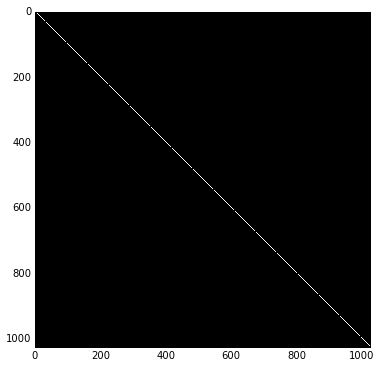

In [24]:
# TODO: Recreate `HSingle` to scan a 32x32 image. `HSingle` is the identity matrix.
HSingle = np.identity(1024)

plt.figure(figsize = (6, 6))
plt.imshow(HSingle, cmap = 'gray', interpolation = 'nearest')
np.save('HSingle.npy', HSingle)

Now that we've saved $H_{Single}$ to a file, we need an object to take a picture of. There are index cards and markers at the GSI desk; **<span style="color:red">take an index card and draw something on its blank (no lines) side. The index card should still be mostly white. Place this index card inside the box so that the projector can project onto it</span>** (see the Overview image). 

**Cory 140**: You can either tape the index card to the side of the box that the projector is projecting onto or you can insert the index card into slots at the far end of the stand (if possible).

**Cory 125**: You'll need to tape the index card to the side of the box that the projector is projecting onto. 

Tape is on the TA desk; do not take the whole dispenser.

**<span style="color:red">Double check that you've done the following before proceeding:</span>**

* Upload `AnalogReadSerial` to the Launchpad.

* Close out of the Energia Serial Monitor.

* Make sure that the ambient light sensor is aimed at the center of the index card! The legs should not be touching.

* Seal the imaging system inside the box to keep outside light out during scanning. If the holes for cables are too big, try to have them face a solid, unmoving object that can block out light.

**<span style="color:red">You will then run the `capture_image.py` script from the following code block that projects mask patterns from $H_{Single}$ onto your image.</span>** 

When running **`capture_image.py`**, a new icon shaped like a white web will appear in the taskbar. The window depicting our masks will appear on the projector's screen. *You can confirm this by looking into the box. (Don't forget to close the box when you're done checking!)*

Before scanning, you will be prompted to specify the **COM port used by the Launchpad and the display associated with the projector.** 

**Select the COM port associated with UART1 (previously accessed in the Energia Serial Monitor and found using the Device Manager) and the 1280x720 projector screen.** Note that you want to specify the index of your choice i.e. for `2) 1280 x 720`, specify 2. **<span style="color:red">Make sure that you selected the correct COM port!</span>**

`capture_image.py` iterates over the rows of the $H$ matrix you made. These rows are translated, one-by-one, into real masks projected onto the screen. Light sensor readings are taken for each mask. At the start of the scan, you'll see a series of `Loc: # Data: #` printed to the output below. `Loc` corresponds to the index $k$ of the current sensor reading (and likewise current row of H). `Data` corresponds to the actual digitized value obtained from the light sensor. This "debug" information is printed consecutively for the first few/last few sensor outputs. Otherwise, this info is printed when `k % 100 = 0` (every 100 scans). 

Don't worry about messages like `Time delta between captures in s: #`. This is printed a lot because the lab computers are kind of slow. 

The whole scanning process should take roughly 3 minutes. 

*Note: On the topic of non-idealities, our scans take so long because:*
* We average sensor readings to improve the signal-to-noise ratio. Therefore we need to read more times.
* As you'll learn in Module 2, capacitors take some time to charge and discharge. A capacitor acts as a "low-pass filter." We used a 0.1$\mu$F capacitor in our sensing circuit to "smooth" the output and suppress "high-frequency" noise. In order to give the capacitor time to "settle" (i.e. ~fully charge/discharge), we need to wait longer between scans. Otherwise, the sensor reading will also include some "memory" of the previous scan result, when we really want the reading to only be about the current scan. 

**<span style="color:red">Not getting a good picture?</span>**

If you selected the incorrect COM port, a lot more "debug" lines will be dumped. You might notice `Data: -1` or `Losing data! Consider increasing your timeout!` messages. Once you see these messages, **save** your Jupyter notebook, then **close the Jupyter notebook in your Terminal (Ctrl+C twice) and re-open it**. You'll lose any saved variables (not output images), but everything you need has been saved to a file. Rerun the following code block again, but **make sure you select the right COM port**. 


EE16A Imaging Lab

Serial timeout in ms: 150
Sleep time in ms: 120
Projector brightness scale in percent: 100
FPS: 40
Image width: 32
Image height: 32
Mask file: HSingle.npy 

Checking serial connections...
Available serial ports:
1) COM1
2) COM15
3) COM16
Select the port to use: 3

Detected 2 screens
Currently displaying on screen 1
1) 1920 x 1080
2) 1280 x 720
Select the projector screen: 2

Period in msecs:  25.0

Starting scan 0... 

Loc: 0 Data: 61 
Time delta between captures in s: 0.15298104286193848
Loc: 1 Data: 66 
Time delta between captures in s: 0.1403059959411621
Loc: 2 Data: 60 
Time delta between captures in s: 0.15634489059448242
Loc: 3 Data: 62 
Time delta between captures in s: 0.15126895904541016
Loc: 4 Data: 66 
Time delta between captures in s: 0.16598200798034668
Loc: 5 Data: 66 
Loc: 6 Data: 67 
Loc: 7 Data: 66 
Loc: 8 Data: 67 
Time delta between captures in s: 0.1662888526916504
Loc: 9 Data: 66 
Time delta between captures in s: 0.1699979305267334
Time delta b

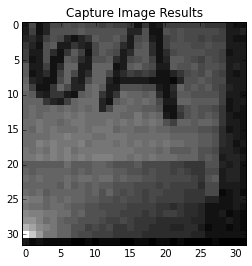

Min sensor reading: 58.0
Max sensor reading: 86.0


In [2]:
%run scripts/helpers.py
%matplotlib inline

%run capture_image.py --mask HSingle.npy --out sensor_readingsHSingle --width 32 --height 32

**<span style="color:red">Recreate the image from the sensor readings obtained with `HSingle`. DO NOT move on until you have an acceptable recreation. Ask for help if you need to.</span>**

*Note: Because we used 32x32 masks this time, the portion of the image we're able to "see" is smaller.*

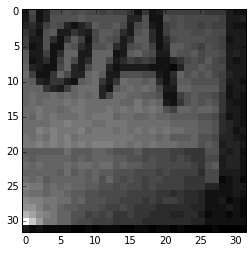

In [32]:
# Sensor readings
sr = np.load('sensor_readingsHSingle_100_0.npy')
HSingle = np.load('HSingle.npy')

# TODO: Create the image vector from `HSingle` and `sr`
# Hint: Because `HSingle` is a special matrix, technically you do not need to perform any matrix operations
iv = sr

img = np.reshape(iv, (32, 32))
plt.imshow(img, cmap = 'gray', interpolation = 'nearest')

## <a id ='realImaging'><span style = "color: blue">Real Multipixel Imaging</span></a>

In the previous section, we scanned our image one pixel at a time. Because only 1 pixel out of 1024 was white, the brightness of the projection was not enough to "saturate" our sensor. Non-linearity was a non-issue! Since our masks now consist of many pixels illuminated simultaneously, we need to check that the brightness of the projected image isn't too high to make non-linearity an issue. And, if we determine that things really are too bright (i.e. sensor values > 3,300), we can compensate by making the "white" pixels slightly darker. 

The steps to do this are a little complicated, so we'll take care of this "non-linearity" calibration for you. Again, if you want to optionally understand this better, check out the [supplement](#nonlinearitySimulation).

**<span style="color:red">Run the following code block. It will return a safe `brightness` value that you will use later. Select the COM port associated with UART1 and the 1280x720 projector screen. This scan should be quick! :)</span>**

*Note: Call a GSI over if an error is reported, because something went wrong. Maybe you forgot to seal your box. However, you can ignore this message: `Incomplete measurement row. Is your mask matrix size correct? Padding outputs 4 times for display.`*


EE16A Imaging Lab

Serial timeout in ms: 150
Sleep time in ms: 120
Projector brightness scale in percent: 100
FPS: 40
Image width: 32
Image height: 32
Mask file: LinearityMatrix.npy 

Checking serial connections...
Available serial ports:
1) COM1
2) COM15
3) COM16
Select the port to use: 3

Detected 2 screens
Currently displaying on screen 1
1) 1920 x 1080
2) 1280 x 720
Select the projector screen: 2

Period in msecs:  25.0

Starting scan 0... 

Loc: 0 Data: 60 
Time delta between captures in s: 0.13349509239196777
Loc: 1 Data: 58 
Time delta between captures in s: 0.1577150821685791
Loc: 2 Data: 58 
Time delta between captures in s: 0.14809703826904297
Loc: 3 Data: 58 
Time delta between captures in s: 0.1564497947692871
Loc: 4 Data: 58 
Loc: 5 Data: 58 
Loc: 6 Data: 58 
Loc: 7 Data: 57 
Loc: 8 Data: 57 
Loc: 9 Data: 57 
Time delta between captures in s: 0.16213607788085938
Time delta between captures in s: 0.16464996337890625
Time delta between captures in s: 0.1627659797668457
Time

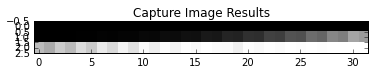

Min sensor reading: 57.0
Max sensor reading: 3750.0
Best valid brightness: 78


In [33]:
%run scripts/helpers.py
%matplotlib inline

# Generate linearity characterization matrix
generateLinearityMatrix(1024)

# Collect sensor data
%run capture_image.py --mask LinearityMatrix.npy --out sensor_readingsLinearityMatrix --width 32 --height 32

# Get ideal projector brightness
brightness = getIdealBrightness(nonlinearityThreshold = 3300)

Now that we've determined the best projector brightness setting, we're ready to start performing real imaging. Recall that we added extra rows to our mask matrices to perform offset characterization. After executing `capture_image.py`, we need to pre-process our data to extract this information out of the sensor reading vector. 

**<span style="color:red">Run the following code block. It will capture sensor readings using the random binary $H$ matrix and provide you with an offset estimate. Select the COM port associated with UART1 and the 1280x720 projector screen.</span>**

*As expected from simulation, you should not be able to make sense of the sensor reading vector `s` at this point. You will have access to the `s` and the offest estimation `oest` that you will then use for reconstruction.*

**<span style="color:red">Troubleshooting!</span>**

If your previous `capture_image.py` run got stuck for whatever reason (i.e. incorrect COM port) and you need to restart your Jupyter notebook, make a note of the `brightness` value from earlier and manually re-assign it below.


EE16A Imaging Lab

Serial timeout in ms: 150
Sleep time in ms: 120
Projector brightness scale in percent: 78
FPS: 40
Image width: 32
Image height: 32
Mask file: H_packaged.npy 

Checking serial connections...
Available serial ports:
1) COM1
2) COM15
3) COM16
Select the port to use: 3

Detected 2 screens
Currently displaying on screen 1
1) 1920 x 1080
2) 1280 x 720
Select the projector screen: 2

Period in msecs:  25.0

Starting scan 0... 

Loc: 0 Data: 60 
Time delta between captures in s: 0.15999603271484375
Loc: 1 Data: 59 
Time delta between captures in s: 0.1600799560546875
Loc: 2 Data: 59 
Time delta between captures in s: 0.15024089813232422
Loc: 3 Data: 58 
Time delta between captures in s: 0.1569840908050537
Loc: 4 Data: 59 
Loc: 5 Data: 59 
Loc: 6 Data: 58 
Loc: 7 Data: 60 
Loc: 8 Data: 60 
Time delta between captures in s: 0.16318202018737793
Loc: 9 Data: 59 
Time delta between captures in s: 0.17035412788391113
Time delta between captures in s: 0.16210699081420898
Time delt

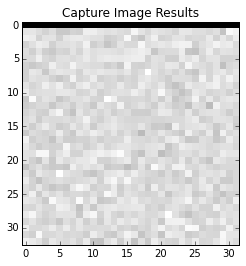

Min sensor reading: 58.0
Max sensor reading: 1800.0


In [8]:
%run scripts/helpers.py
%matplotlib inline

# Run scan
# Example for brightness value 100:
# %run capture_image.py --mask H_packaged.npy --out sensor_readingsH --width 32 --height 32 --brightness 100
# Make sure to delete the #'s
# TODO: Add brightness value to the end
%run capture_image.py --mask H_packaged.npy --out sensor_readingsH --width 32 --height 32 --brightness 78

sr = np.load('sensor_readingsH_%s_0.npy' % str(brightness))
# Estimate the offset
oest_H, s_H = getOffsetEstimateAndS(sWithOffsetCalibration = sr)

**<span style="color:red">Let's reconstruct your image from `s_H`, `oest_H`, and `H`. Based off of your simulation results, is this the reconstruction quality that you expected using `H`? Think about how noisy our actual imaging system is.</span>**

*Hint: You already helped to write the function `reconstructionWithOffsetRemoval` (which you might need to reload if you restarted your Jupyter notebook).*

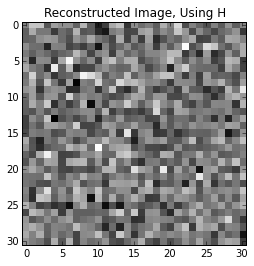

In [34]:
H = np.load('H.npy')

reconstructionWithOffsetRemoval(H = H, matrixName = 'H', s = s_H, oest = oest_H)

**As expected, the randomly genereated H matrix does not work well, if at all.**

Next, let's try to image your index card using `mysteryH`. Imaging with `mysteryH` requires some additional pre-processing to stitch sensor readings (associated with the mask that we split) back together. This has been taken care of for you in the code below. 

**<span style="color:red">Run the following code block. It will capture sensor readings using the mystery matrix `mysteryH` and provide you with an offset estimate. Select the COM port associated with UART1 and the 1280x720 projector screen.</span>**

*Note: Don't worry about this error message: "`Incomplete measurement row. Is your mask matrix size correct? Padding outputs 31 times for display.`" IF it states that outputs are padded exactly 31 times. This is due to the fact that `mysteryH`'s row 0 is split.*


EE16A Imaging Lab

Serial timeout in ms: 150
Sleep time in ms: 120
Projector brightness scale in percent: 78
FPS: 40
Image width: 32
Image height: 32
Mask file: mysteryH_packaged.npy 

Checking serial connections...
Available serial ports:
1) COM1
2) COM15
3) COM16
Select the port to use: 3

Detected 2 screens
Currently displaying on screen 1
1) 1920 x 1080
2) 1280 x 720
Select the projector screen: 2

Period in msecs:  25.0

Starting scan 0... 

Loc: 0 Data: 61 
Time delta between captures in s: 0.15749883651733398
Loc: 1 Data: 59 
Time delta between captures in s: 0.15610313415527344
Loc: 2 Data: 58 
Time delta between captures in s: 0.15705585479736328
Loc: 3 Data: 57 
Time delta between captures in s: 0.1501610279083252
Loc: 4 Data: 58 
Loc: 5 Data: 58 
Loc: 6 Data: 58 
Loc: 7 Data: 57 
Loc: 8 Data: 59 
Loc: 9 Data: 59 
Time delta between captures in s: 0.16666412353515625
Time delta between captures in s: 0.1700291633605957
Time delta between captures in s: 0.16997885704040527
Ti

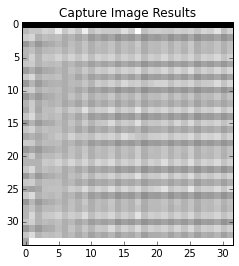

Min sensor reading: 57.0
Max sensor reading: 3607.0


In [35]:
%run scripts/helpers.py
%matplotlib inline

# TROUBLESHOOTING: Change to the previously optimized brightness value if you restarted Jupyter 
brightness = brightness

# Run scan
# Example for brightness value 100:
# %run capture_image.py --mask H_packaged.npy --out sensor_readingsH --width 32 --height 32 --brightness 100
# Make sure to delete the #'s
# TODO: Add brightness value to the end
%run capture_image.py --mask mysteryH_packaged.npy --out sensor_readingsmysteryH --width 32 --height 32 --brightness 78

# PREPROCESSING -------------------------------------------------------------------

sr = np.load('sensor_readingsmysteryH_%s_0.npy' % str(brightness))
# Estimate the offset
oest_mysteryH, sRow0Split = getOffsetEstimateAndS(sWithOffsetCalibration = sr)
# Combine rows 0a, 0b of `s` 
s_mysteryH = getMysteryS(sRow0Split)

**<span style="color:red">Let's reconstruct your image from `s_mysteryH`, `oest_mysteryH`, and `mysteryH`. Based off of your simulation results, is this the reconstruction quality that you expected using `mysteryH`?</span>**

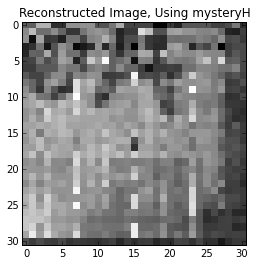

In [37]:
mysteryH = np.load('mysteryH.npy')

#reconstructionWithOffsetRemoval(H = mysteryH, matrixName = 'mysteryH', s = s_mysteryH, oest = oest_mysteryH)
reconstructionWithOffsetRemoval(H = mysteryH, matrixName = 'mysteryH', s = s_mysteryH, oest = oest_mysteryH, realImaging = True)

** Note: If the previous code block returned low-contrast results (with certain pixels that are unusually dark or unusually bright, run the (currently commented out) second version of `reconstructionWithOffsetRemoval` instead of the first version (which is used by default).**

**<span style="color:red">Comment on your reconstruction results when using `H` and `mysteryH`. In real imaging, which matrix did better? Did this match your expectations from simulation? Why? How did you expect multipixel imaging to compare to single pixel imaging from Imaging 2? What are some observed limitations of multipixel imaging?</span>**

mysteryH did better, but it is a mystery why it is so poor. this matches our expectations, 

<a id='checkoff'></a>
## Checkoff
When you are ready to get checked off, please go to: https://goo.gl/forms/6yCLuz9FfTJRQKcq2. Fill out one form per person in your group. Follow the form exactly and submit. Your GSI or a Lab Assistant will come by once they are available and go through some checkoff questions with your group.

### **Everything after here is optional but very interesting (and should only take a couple extra minutes)!**

---


### <a id = 'omp'><span style = "color: blue">Taste for the Future *(Advanced Techniques)*</span></a>

One big takeaway from this lab is that performing *real imaging* isn't as easy as you'd think. As we've seen, reconstruction via matrix inversion only "works" when 1) your imaging system isn't too noisy and 2) the matrix that you're inverting is "well-conditioned" (meaning that it doesn't have small eigenvalues that would result in noise amplification upon inversion). Unfortunately, you have no control over 1) and it's actually *really hard* to generate "well-conditioned" matrices.

Additionally, scanning takes a *long* time. :(

**So then the questions arise: Is there another reconstruction method that is more robust to noise? Can you reduce the amount of scans you need to take and still get a reasonable reconstruction?**

#### <span style = "color: blue">Compressed Sensing Magic (Orthogonal Matching Pursuit)</span></a>

In Module 3, you'll learn about a really cool technique called Orthogonal Matching Pursuit (OMP) that addresses both questions above. OMP attempts to solve equations of the form $A \vec{x} = \vec{b}$. Specifically, it enables you to recover an $n$-length vector $\vec{x}$ from fewer than $n$ *noisy* measurements, *assuming that $\vec{x}$ is "sparse" in some basis* and $A$ is known. Our image is sparse in a special basis that you'll learn about in future classes, so we can use OMP! Actually, this fact enables techniques like JPEG image compression! You don't need to worry about the details now, but here's a little preview of the problem formulation in case you're curious. Recall that our ideal imaging system is modeled as:

$$ \vec{s} = H \vec{i} $$

Our image column vector $\vec{i}$ is not sparse. That means that most elements in $\vec{i}$ are non-zero (the card is mostly white). However, our image represented in a special domain as $\vec{x}$ *is sparse*. That is, the elements of $\vec{x}$ are mostly zero. There is a relationship between our image represented as  $\vec{i}$ and our image represented as $\vec{x}$:

$$ \vec{i} = M_{IDCT} \vec{x} $$

Where $M_{IDCT}$ is a transformation matrix that allows us to go between these two domains. Because of this relation, we can reformulate the mathematical model of our imaging system as:

$$ \vec{s} = H M_{IDCT} \vec{x} $$

If $H$ and $M_{IDCT}$ are square matrices with dimensions $n \times n$, $A = H M_{IDCT}$ will be a matrix with the same dimensions. Since $\vec{x}$ *is sparse* (and we have $H M_{IDCT}$ and an estimate of $\vec{s}$), we can use OMP to solve for $\vec{x}$, and then back track to obtain what we actually care about: an estimate of $\vec{i}$.

**<span style="color:red">Run the following code block so you'll have access to OMP functionality. Again, don't worry about what's going on. We just want to show you something cool. :)</span>**

In [ ]:
%run scripts/helpers.py
%matplotlib inline

# TROUBLESHOOTING: Change to the previously optimized brightness value if you restarted Jupyter 
brightness = brightness

# Inputs
#  `percentMeasurements`: Number of measurements to take, expressed as a percentage of n (length of i)
#  `imDims`: Image dimensions [height, width]
#  `sparsity`: Expected # of non-zero elements of x
def OMP_DCT(percentMeasurements, brightness, imDims = [32, 32], sparsity = 300):
    numPixels = imDims[0] * imDims[1]
    identity = np.eye(numPixels)
    
    # Generate IDCT "dictionary"
    MIDCT = fftpack.idct(identity)
    
    # A = H * MIDCT
    H = np.load("H.npy")
    A = np.dot(H, MIDCT)
    
    # Get sensor readings
    sr = np.load('sensor_readingsH_%s_0.npy' % str(brightness))
    # Estimate the offset AND REMOVE IT
    oest_H, s_H = getOffsetEstimateAndS(sWithOffsetCalibration = sr)
    # b = A * x
    b = s_H - oest_H
    
    # Calculate number of measurements used for reconstruction
    numMeasurements = int(percentMeasurements / 100.0 * numPixels)
    AShort = A[:numMeasurements]
    measurements = b[:numMeasurements]
    
    # Perform OMP to get x. Then get back i
    OMP_GS(imDims = imDims, sparsity = sparsity, measurements = measurements, A = AShort, MIDCT = MIDCT);

Now let's give OMP a shot. To save time, we won't have you capture your image again, but we'll use some % of the rows of `H` and `s`, and see if we can still reconstruct a reasonable image with OMP. If our original scans took ~3 minutes, using 50% of the rows would correspond to a new scan time of 1.5 minutes. 

**<span style="color:red">Run the next several code blocks to see how OMP-based reconstruction improves with more measurements (more scans and rows of `H` and `s`). If you watch the reconstruction step-by-step, you'll also notice how reconstruction gets better with each "iteration" of the algorithm.</span>**

In [ ]:
OMP_DCT(percentMeasurements = 10, brightness = brightness)

In [ ]:
OMP_DCT(percentMeasurements = 20, brightness = brightness)

In [ ]:
OMP_DCT(percentMeasurements = 30, brightness = brightness)

In [ ]:
OMP_DCT(percentMeasurements = 40, brightness = brightness)

In [ ]:
OMP_DCT(percentMeasurements = 50, brightness = brightness)

In [ ]:
OMP_DCT(percentMeasurements = 60, brightness = brightness)

In [ ]:
OMP_DCT(percentMeasurements = 70, brightness = brightness)

In [ ]:
OMP_DCT(percentMeasurements = 80, brightness = brightness)

In [ ]:
OMP_DCT(percentMeasurements = 90, brightness = brightness)

In [ ]:
OMP_DCT(percentMeasurements = 100, brightness = brightness)

Remember that the reconstruction using $H^{-1}$ was really bad! With OMP using the same $H$, we can get significantly better reconstruction with fewer scans!
<!-- The last rows aren't going to be approximately orthogonal to the previous rows of A, so diminishing returns. -->

### <a id = 'nonidealities'><span style = "color: blue">Delving Further Into Non-Idealities</span></a>

#### <a id = 'nonlinearitySimulation'><span style = "color: blue">Non-Linearity, Unabridged</span></a>

To better understand how our imaging system behaves, we previously characterized the "linearity" of our setup under a set of conditions that are similar to (but not necessarily the same as--the x axis has been scaled differently) the ones you encounter in lab. We used an almost white image and a custom mask matrix to map the number of illuminated pixels displayed by the projector to the digitized sensor output value. This is a very important characterization step that circuit designers have to perform all the time. The **blue** line indicates what we'd ideally like to see. <br/><br/>

<center>
**Linearity Plot**
<img src="images/linearity.png" align="center" style="height:300px;"/>
</center>

**<span style="color:red">In an ideal system (without nonlinear distortion), how should the sensor output value change with an increasing number of illuminated pixels?</span>**

**<span style="color:red">Your Answer Here!</span>**

It's evident from observing the **orange** plot (derived from measured results) that our sensor saturates at high brightness. That is, **above a y-value of approximately 3,400, any large increase in # of illuminated pixels (say from 600 to 720 and beyond) does not result in a similarly large increase in the sensor output value**. You'll notice that the sensor value actually increases slightly as the # of illuminated pixels increases from 600 to 720. However, it's easiest to model this "clipping" effect as an abrupt transition, so that beyond ~600 illuminated pixels, the sensor reading is basically constant (**black plot**).   

<!-- We actually use binary matrices because of nonlinearity with respect to pixel brightness. If you want to maximize SNR while still operating in a linear region, what's the average # of pixels you want to have lit up? -->

We provide you with a function `simulateCaptureWithNoiseOffsetClip` that builds on the output of `simulateCaptureWithNoiseAndOffset` to model the clipping behavior of our system i.e., if a sensor reading exceeds some value `clipThreshold`, it should be set to `clipThreshold`. This new function models all of the non-idealities we consider for this lab. 

**<span style="color:red">Run the cell below to have access to `simulateCaptureWithNoiseOffsetClip`.</span>**

*Warning: The remaining code blocks depend on functions that may need to be re-loaded if you exited out of your Jupyter notebook at any time.*

In [ ]:
# Inputs: 
#  `i2D`: 2D image you're trying to capture
#  `H`: Mask matrix
#  `matrixName`: Name of mask matrix (for image title)
#  `o`: Undesired offset (i.e. for a projected dark image)
#  `sigma`: Amount of noise to add (noise standard deviation)
#  `clipThreshold`: Ideal sensor (y) value above which to clip the sensor output
# Outputs:
#  `s`: Clipped sensor reading column vector with noise + undesired offset added

# Default clipThreshold set to be very high, so effectively there's no clipping
def simulateCaptureWithNoiseOffsetClip(i2D, H, matrixName, o, sigma, clipThreshold = 1000000):
    s = simulateCaptureWithNoiseAndOffset(i2D = i2D, H = H, matrixName = matrixName, o = o, sigma = sigma)
    
    # Clip elements in s if they exceed `clipThreshold`
    for i in range(len(s)):
        if (s[i] > clipThreshold):
            s[i] = clipThreshold
            
    return s;

**<span style="color:red">Run the following block to show how clipping affects the reconstructed output when `H` is used (and noise `sigma = 0.001`, offset `o = 0`). A *simulation-only* `clipThreshold = 5700` was chosen. It's not meant to be indicative of the real system's clipping threshold. The histograms of the simulated `s` are also plotted both `with and without clipping`.</span>**

In [ ]:
i2D = np.load('scripts/raw_card.npy')
H = np.load('H.npy')

# Ideal capture
s = simulateIdealCapture(i2D = i2D, H = H, matrixName = 'H', display = False)

# Capture with sensor clipping
sClip = simulateCaptureWithNoiseOffsetClip(i2D = i2D, H = H, matrixName = 'H', o = 0, sigma = 0.001, clipThreshold = 5700)

print("Reconstruction with Clipping")
idealReconstruction(H = H, matrixName = 'H', s = sClip)

# Histograms of `s` with and without clipping
plt.hist(s, bins = 100)
plt.title('s (No Clipping)')
plt.show()

plt.hist(sClip, bins = 100)
plt.title('s (Clipped)')
plt.show()

**<span style="color:red">What can we do to `H` to prevent `s` from clipping in our imaging *simulator*? We want to perform the same operation on all elements of `H`.</span>**

*Hint: This operation decreases the signal we can measure by shifting the bins of our histogram to the left, which is bad for SNR :(, but let's not worry about that for now.*

**<span style="color:red">Your Answer Here!</span>**

**<span style="color:red">Let's see that this worked in simulation. How should `H` be transformed? (1 line TODO) A new histogram for `sClip` (obtained using the transformed `scaledH`) is also generated.</span>**

In [ ]:
# TODO: Perform an operation on `H` that affects all of its elements the same way to ensure that there's no clipping. -
scaledH = # YOUR CODE HERE

sClip = simulateCaptureWithNoiseOffsetClip(i2D = i2D, H = scaledH, matrixName = 'Scaled H', o = 0, sigma = 0.001, clipThreshold = 5700)

# Notice that `H` can be used here
idealReconstruction(H = H, matrixName = 'Scaled H', s = sClip)

# Histogram for the new `sClip`
plt.hist(sClip, bins = 100)
plt.title('s (Clipped), using Scaled H')

**Depending on how you setup your imaging system and how good your components were, you might've needed to do this during real imaging. The code that returned the safe `brightness` figured out the requisite projector brightness, and the brightness settings were adjusted accordingly when `capture_image.py` was run.**

<!-- 
plt.figure(figsize = (10, 5)) 
plt.imshow(mysteryH[:20], cmap = 'gray', aspect = 20)
plt.title('First 20 Rows of Mystery H')
plt.show()
-->

The first 20 rows of `mysteryH` are shown, zoomed in, below:<br/><br/>

<center><img src="images/mysteryH.png" align="center" style="height:250px;"/></center>

An interesting property of this `mysteryH` is that the 0th row consists entirely of 1's, while only half the columns of subsequent rows consist of 1's. 

**<span style="color:red">Given the `Linearity Plot` from before and considering how many pixels are illuminated in each row of `mysteryH` (row 0 and other rows), why is this problematic for our imaging system?</span>**

*Note: The Linearity Plot indicates that the sensor output is expected to stay constant at ~3,800 for # of illuminated pixels >600.*

**<span style="color:red">Your Answer Here!</span>**

We correct for this problem by splitting row 0 of `mysteryH` into 2 (so that the number of illuminated pixels in row 0a and row0b is the same as the number of illuminated pixels in all other rows). Before we perform reconstruction, we stitch the sensor readings corresponding to row 0a and row 0b back together by summing them to get an effective $sr_0$. You used this code when you did real imaging.

### <a id = 'offset'>Offset Calibration Code</a> 
The "black characterization" step is accomplished by appending 32 rows (`numCalibrationMeasurements`; number chosen arbitrarily) consisting entirely of 0's to the top of the $H$ matrix. This new matrix `HWithOffsetCalibration` will be used by the imaging system (=projector). The sensor reading column vector $\vec{s}$ will now be 32 elements longer (called `sWithOffsetCalibration`), but the first 32 sensor readings will not be directly used to reconstruct our image. Instead, they will be averaged to get an estimate of the offset, which will be used for "offset calibration."